# Multi-Class Deep Learning Model for CIFAR-10 Object Recognition Using Keras Take 4
### David Lowe
### January 6, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The CIFAR-10 dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: The CIFAR-10 is a labeled subset of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5,000 images from each class.

In iteration Take1, we constructed a simple VGG convolutional model with 1 VGG block to classify the images. This model serves as the baseline for the future iterations of modeling.

In iteration Take2, we constructd a few more VGG convolutional models with 2 and 3 VGG blocks to classify the images. The additional models enabled us to choose a final baseline model before applying other performance-enhancing techniques.

In iteration Take3, we tuned the VGG-3 model with various hyperparameters and select the best model.

In this iteration, we will add some dropout layers as a regularization technique to reduce over-fitting.

ANALYSIS: In iteration Take1, the performance of the Take1 model with the default parameters achieved an accuracy score of 66.39% on the validation dataset after training for 50 epochs. After tuning the hyperparameters, the Take1 model with the best hyperparameters processed the training dataset with an accuracy of 100.00%. The same model, however, processed the test dataset with an accuracy of only 67.01%. We will need to explore other modeling approaches to make a better model that reduces over-fitting.

In iteration Take2, the performance of the VGG-1 model with the default parameters achieved an accuracy score of 66.69% on the validation dataset after training for 50 epochs. The VGG-2 model achieved an accuracy score of 71.35% on the validation dataset after training for 50 epochs. The VGG-3 model achieved an accuracy score of 73.81% on the validation dataset after training for 50 epochs. The additional VGG blocks helped the model, but we still need to explore other modeling approaches to make a better model that reduces over-fitting.

In iteration Take3, the performance of the VGG-3 Take3 model with the default parameters achieved a maximum accuracy score of 73.43% on the validation dataset after training for 50 epochs. After tuning the hyperparameters, the Take1 model with the best hyperparameters processed the training dataset with an accuracy of 98.09%. The same model, however, processed the test dataset with an accuracy of only 73.44%. Even with VGG-3 and hyperparameter tuning, we still have an over-fitting problem with the model.

In this iteration, the performance of the Take4 model with the default parameters achieved a maximum accuracy score of 76.96% on the validation dataset after training for 50 epochs. We can see from the graph that the accuracy and loss curves for the training and validation sets were moving in the same direction and converged well. After increasing the number of epochs, the Take4 model processed the training dataset with an accuracy of 82.22% after 100 epochs. The same model processed the test dataset with an accuracy of 82.35%. This iteration indicated to us that having dropout layers can be a good tactic to improve the model's predictive performance.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: The CIFAR-10 Dataset

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://www.cs.toronto.edu/~kriz/cifar.html

One potential source of performance benchmarks: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

Any deep-learning modeling project genrally can be broken down into about six major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# import keras as K
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_kernel_init = tf.initializers.he_uniform(seed=seedNum)
default_optimizer = tf.optimizers.SGD(learning_rate=0.001, momentum=0.9)
default_epoch = 50
default_batch = 64

Num GPUs Available:  1


In [5]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [6]:
# Reset the random number generators
def reset_random(seedNum):
    random.seed(seedNum)
    np.random.seed(seedNum)
    tf.random.set_seed(seedNum)

In [7]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [8]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [9]:
cifar10 = tf.keras.datasets.cifar10
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

# Summarize loaded datasets
print('Train Shape: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test Shape: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train Shape: X=(50000, 32, 32, 3), y=(50000, 1)
Test Shape: X=(10000, 32, 32, 3), y=(10000, 1)


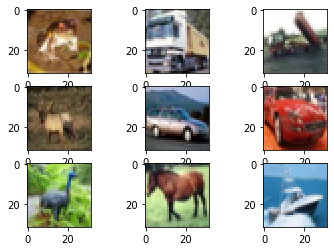

In [10]:
# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## 1.b) Data Cleaning

In [11]:
# Not required for this iteration of the project

## 1.c) Feature Scaling and Pre-processing

In [12]:
# Reshape the input data as [samples][width][height][channels]
# X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
# X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Apply feature scaling and transformation
X_train = X_train / 255.0
X_test = X_test / 255.0

## 1.d) Splitting Data into Training and Test Sets

In [13]:
# Encode class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
train_transformed = encoder.transform(y_train)
test_transformed = encoder.transform(y_test)
y_train = tf.keras.utils.to_categorical(train_transformed)
y_test = tf.keras.utils.to_categorical(test_transformed)

print('Train Shape: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test Shape: X=%s, y=%s' % (X_test.shape, y_test.shape))

num_pixels = X_train.shape[1] * X_train.shape[2]
print('Number of pixels:', num_pixels)
num_classes = y_train.shape[1]
print('Number of classes:', num_classes)

Train Shape: X=(50000, 32, 32, 3), y=(50000, 10)
Test Shape: X=(10000, 32, 32, 3), y=(10000, 10)
Number of pixels: 1024
Number of classes: 10


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [15]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [16]:
# Define the Keras model for baseline measurement
def create_default_model():
    default_model = Sequential()
    default_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same', input_shape=(32, 32, 3)))
    default_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(MaxPooling2D((2, 2)))
    default_model.add(Dropout(0.2))
    default_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(MaxPooling2D((2, 2)))
    default_model.add(Dropout(0.3))
    default_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=default_kernel_init, padding='same'))
    default_model.add(MaxPooling2D((2, 2)))
    default_model.add(Dropout(0.4))
    default_model.add(Flatten())
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dropout(0.5))
    default_model.add(Dense(num_classes, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [17]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [18]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [19]:
# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch,
                                   validation_data=(X_test, y_test), verbose=1)
print('Total time for creating the baseline model:', (datetime.now() - startTimeModule))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 21s 411us/sample - loss: 2.2210 - accuracy: 0.1613 - val_loss: 2.0415 - val_accuracy: 0.2544
Epoch 2/50
50000/50000 [==============================] - 15s 303us/sample - loss: 1.9702 - accuracy: 0.2527 - val_loss: 1.7659 - val_accuracy: 0.3564
Epoch 3/50
50000/50000 [==============================] - 15s 300us/sample - loss: 1.7731 - accuracy: 0.3286 - val_loss: 1.7320 - val_accuracy: 0.3762
Epoch 4/50
50000/50000 [==============================] - 15s 299us/sample - loss: 1.6730 - accuracy: 0.3759 - val_loss: 1.5613 - val_accuracy: 0.4304
Epoch 5/50
50000/50000 [==============================] - 15s 296us/sample - loss: 1.5940 - accuracy: 0.4074 - val_loss: 1.4441 - val_accuracy: 0.4842
Epoch 6/50
50000/50000 [==============================] - 15s 301us/sample - loss: 1.5248 - accuracy: 0.4379 - val_loss: 1.3586 - val_accuracy: 0.5071
Epoch 7/50
50000/50000 [====================

In [20]:
# Display a summary of the baseline model
print(baseline_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [21]:
# Display the configuration of the baseline model
print(baseline_model.get_config())

{'name': 'sequential', 'layers': [{'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling'

In [22]:
# List all data points in the baseline model training history
print(baseline_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


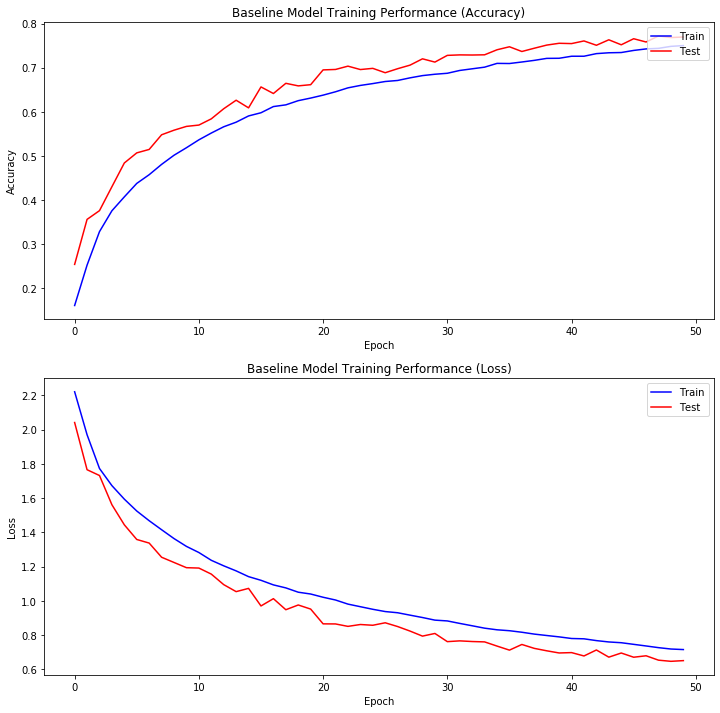

In [23]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Baseline Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [24]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [25]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [26]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_init, padding='same', input_shape=(32, 32, 3)))
    customized_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_init, padding='same'))
    customized_model.add(MaxPooling2D((2, 2)))
    customized_model.add(Dropout(0.2))
    customized_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_init, padding='same'))
    customized_model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_init, padding='same'))
    customized_model.add(MaxPooling2D((2, 2)))
    customized_model.add(Dropout(0.3))
    customized_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_init, padding='same'))
    customized_model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_init, padding='same'))
    customized_model.add(MaxPooling2D((2, 2)))
    customized_model.add(Dropout(0.4))
    customized_model.add(Flatten())
    customized_model.add(Dense(128, activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dropout(0.5))
    customized_model.add(Dense(num_classes, activation='softmax', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [27]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [28]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
# Last modifications to the model to improve its effectiveness
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = int(default_epoch * 2)
best_batch = default_batch

In [32]:
# Create the final model for evaluating the test dataset
startTimeModule = datetime.now()
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
reset_random(seedNum)
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, validation_data=(X_test, y_test), verbose=1)
print('Total time for training the final model:', (datetime.now() - startTimeModule))

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x7f45e87a8978>, kernel=<tensorflow.python.ops.init_ops_v2.VarianceScaling object at 0x7f45e87a8898>, epochs=100, batch_size=64
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 17s 330us/sample - loss: 2.2224 - accuracy: 0.1611 - val_loss: 2.0384 - val_accuracy: 0.2588
Epoch 2/100
50000/50000 [==============================] - 15s 306us/sample - loss: 1.9672 - accuracy: 0.2548 - val_loss: 1.7782 - val_accuracy: 0.3631
Epoch 3/100
50000/50000 [==============================] - 15s 306us/sample - loss: 1.7703 - accuracy: 0.3315 - val_loss: 1.7027 - val_accuracy: 0.3833
Epoch 4/100
50000/50000 [==============================] - 15s 307us/sample - loss: 1.6730 - accuracy: 0.3722 - val_loss: 1.5953 - val_accuracy: 0.4211
Epoch 5/100
50000/50000 [==============================] - 15s 306us/sample - loss: 1.5940 - accuracy: 0

In [33]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

In [34]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_2', 'layers': [{'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'batch_input_shape': (None, 32, 32, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 2.0, 'mode': 'fan_in', 'distribution': 'uniform', 'seed': 888}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScal

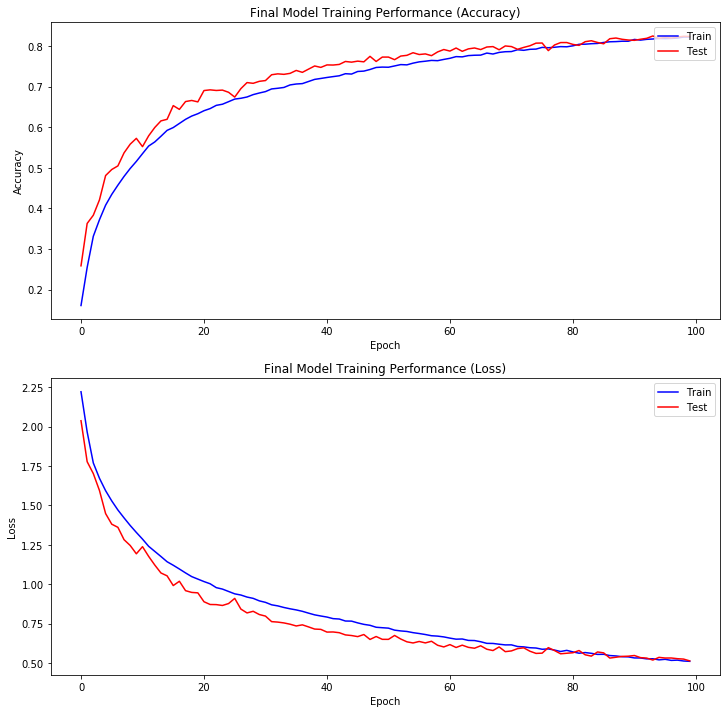

In [35]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(final_hist.history['accuracy'], color='blue', label='train')
plt.plot(final_hist.history['val_accuracy'], color='red', label='test')
plt.title('Final Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(final_hist.history['loss'], color='blue', label='train')
plt.plot(final_hist.history['val_loss'], color='red', label='test')
plt.title('Final Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [36]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %s (expected %s)' % (i, encoder.inverse_transform([predictions[i]]), encoder.inverse_transform([np.argmax(y_test[i])])))

Data item #0 predicted to be [3] (expected [3])
Data item #1 predicted to be [8] (expected [8])
Data item #2 predicted to be [8] (expected [8])
Data item #3 predicted to be [8] (expected [0])
Data item #4 predicted to be [6] (expected [6])
Data item #5 predicted to be [6] (expected [6])
Data item #6 predicted to be [1] (expected [1])
Data item #7 predicted to be [6] (expected [6])
Data item #8 predicted to be [3] (expected [3])
Data item #9 predicted to be [1] (expected [1])
Data item #10 predicted to be [0] (expected [0])
Data item #11 predicted to be [9] (expected [9])
Data item #12 predicted to be [5] (expected [5])
Data item #13 predicted to be [7] (expected [7])
Data item #14 predicted to be [9] (expected [9])
Data item #15 predicted to be [8] (expected [8])
Data item #16 predicted to be [5] (expected [5])
Data item #17 predicted to be [7] (expected [7])
Data item #18 predicted to be [8] (expected [8])
Data item #19 predicted to be [6] (expected [6])


In [37]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:47:26.527963
